In [ ]:
#instalar bibliotecas extras

!pip install -q opencv-python seaborn

In [ ]:
#imports principais

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     Flatten, Dense, BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.19.0


In [ ]:
#carregar o FER2013

import kagglehub
import os

# Download latest version
caminho_diretorio = kagglehub.dataset_download("deadskull7/fer2013")

# O dataset é baixado para um diretório, precisamos encontrar o arquivo CSV dentro dele
caminho_csv = os.path.join(caminho_diretorio, "fer2013.csv")

dados = pd.read_csv(caminho_csv)
print("Formato do dataset:", dados.shape)
dados.head()

Using Colab cache for faster access to the 'fer2013' dataset.
Formato do dataset: (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
#separar conjuntos e preparar imagens/rotulos

# Dicionário com nomes das emoções (ordem padrão do FER2013)
mapa_emocoes = {
    0: "Raiva",     # Angry
    1: "Nojo",      # Disgust
    2: "Medo",      # Fear
    3: "Feliz",     # Happy
    4: "Triste",    # Sad
    5: "Surpreso",  # Surprise
    6: "Neutro"     # Neutral
}

def preparar_conjunto(df_parcial):
    """
    Converte a coluna 'pixels' em array de imagens 48x48x1 normalizadas
    e transforma 'emotion' em one-hot (7 classes).
    """
    # 'pixels' é uma string com 2304 valores (48*48) separados por espaço
    lista_pixels = df_parcial["pixels"].str.split(" ").tolist()
    imagens = np.array(lista_pixels, dtype='float32')
    imagens = imagens.reshape(-1, 48, 48, 1)  # (N, 48, 48, 1)
    imagens = imagens / 255.0                 # normalização [0,1]

    rotulos = df_parcial["emotion"].values
    rotulos = to_categorical(rotulos, num_classes=7)

    return imagens, rotulos

# Separar por Usage
dados_treino = dados[dados["Usage"] == "Training"]
dados_val    = dados[dados["Usage"] == "PublicTest"]
dados_teste  = dados[dados["Usage"] == "PrivateTest"]

X_treino, y_treino = preparar_conjunto(dados_treino)
X_val,    y_val    = preparar_conjunto(dados_val)
X_teste,  y_teste  = preparar_conjunto(dados_teste)

print("Treino:", X_treino.shape, y_treino.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_teste.shape, y_teste.shape)


Treino: (28709, 48, 48, 1) (28709, 7)
Validação: (3589, 48, 48, 1) (3589, 7)
Teste: (3589, 48, 48, 1) (3589, 7)


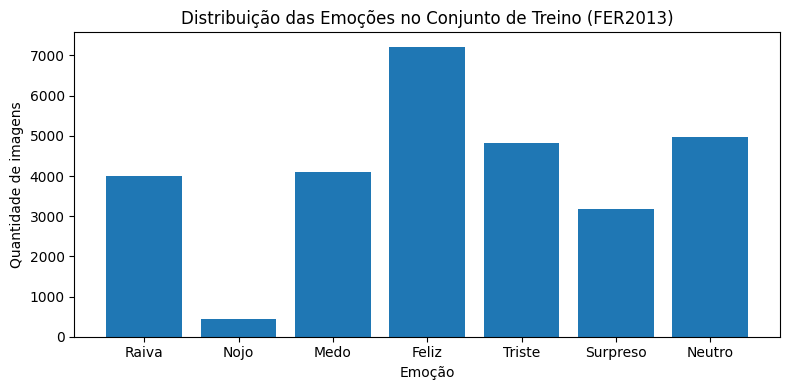

In [ ]:
# Distribuição das emoções no conjunto de treino

df_treino = dados[dados["Usage"] == "Training"]

contagem_treino = df_treino["emotion"].value_counts().sort_index()
labels_treino = [mapa_emocoes[i] for i in contagem_treino.index]

plt.figure(figsize=(8, 4))
plt.bar(labels_treino, contagem_treino.values)
plt.title("Distribuição das Emoções no Conjunto de Treino (FER2013)")
plt.xlabel("Emoção")
plt.ylabel("Quantidade de imagens")
plt.tight_layout()
plt.show()


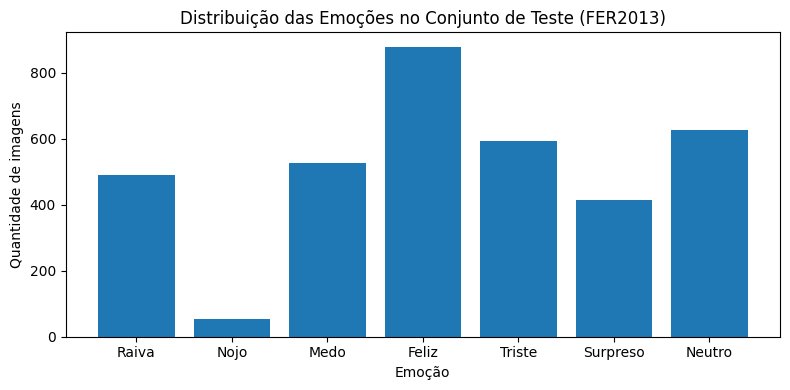

In [ ]:
# Distribuição das emoções no conjunto de teste

df_teste = dados[dados["Usage"] == "PrivateTest"]

contagem_teste = df_teste["emotion"].value_counts().sort_index()
labels_teste = [mapa_emocoes[i] for i in contagem_teste.index]

plt.figure(figsize=(8, 4))
plt.bar(labels_teste, contagem_teste.values)
plt.title("Distribuição das Emoções no Conjunto de Teste (FER2013)")
plt.xlabel("Emoção")
plt.ylabel("Quantidade de imagens")
plt.tight_layout()
plt.show()


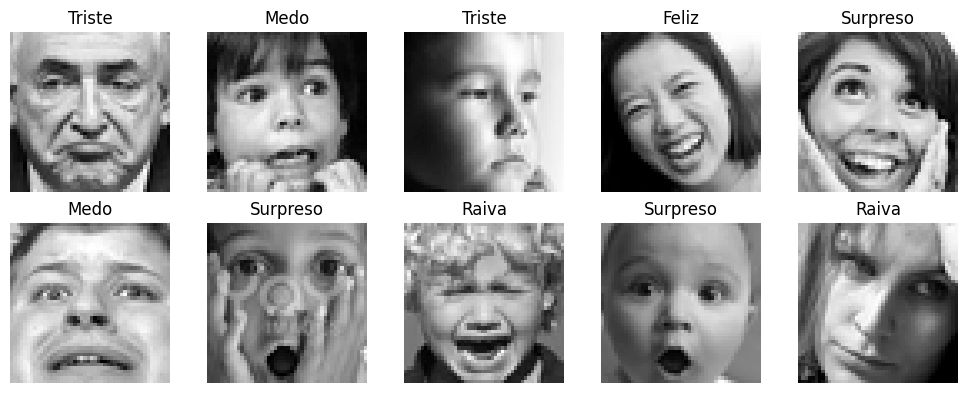

In [ ]:
#mostrar algumas imagens do conjunto de treino

plt.figure(figsize=(10, 4))

for i in range(10):
    idx = np.random.randint(0, X_treino.shape[0])
    imagem = X_treino[idx].reshape(48, 48)
    rotulo = np.argmax(y_treino[idx])
    nome_emocao = mapa_emocoes[rotulo]

    plt.subplot(2, 5, i+1)
    plt.imshow(imagem, cmap="gray")
    plt.title(nome_emocao)
    plt.axis("off")

plt.tight_layout()
plt.show()


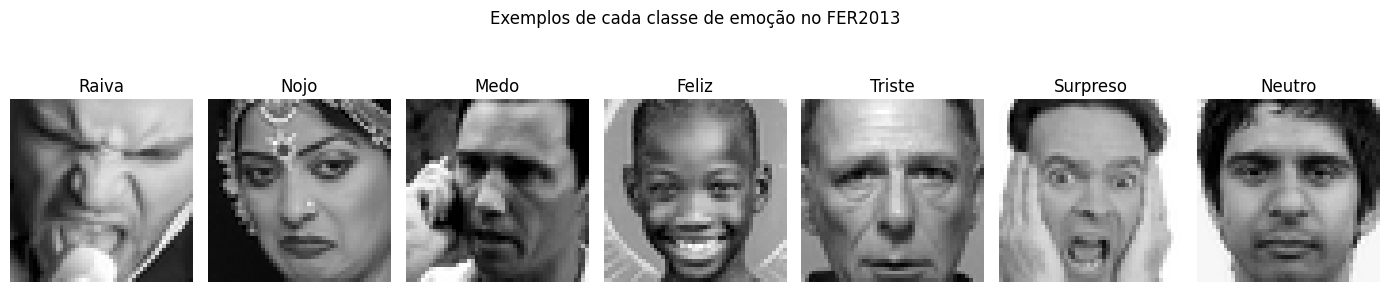

In [ ]:
# Um exemplo de cada emoção presente no conjunto de treino

plt.figure(figsize=(14, 3))

for classe in range(7):
    # índices dessa classe no treino
    indices_classe = np.where(np.argmax(y_treino, axis=1) == classe)[0]

    # escolhe um exemplo aleatório dessa classe
    idx_escolhido = np.random.choice(indices_classe)

    img = X_treino[idx_escolhido].reshape(48, 48)

    plt.subplot(1, 7, classe + 1)
    plt.imshow(img, cmap="gray")
    plt.title(mapa_emocoes[classe])
    plt.axis("off")

plt.suptitle("Exemplos de cada classe de emoção no FER2013", y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
# geradores de dados (data augmentation)

gerador_treino = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

gerador_treino.fit(X_treino)

# Validação e teste sem augmentation
gerador_val = ImageDataGenerator()
gerador_teste = ImageDataGenerator()

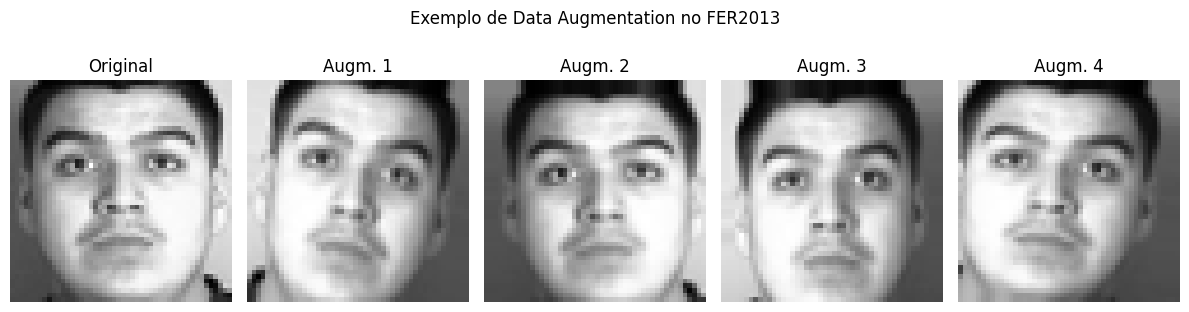

In [ ]:
# Exemplo visual de Data Augmentation aplicado a uma imagem

# escolhe uma imagem qualquer do treino
idx = np.random.randint(0, X_treino.shape[0])
imagem_base = X_treino[idx]  # (48, 48, 1)

# precisa colocar no formato (1, 48, 48, 1) para o ImageDataGenerator
amostra = np.expand_dims(imagem_base, axis=0)

iterador = gerador_treino.flow(amostra, batch_size=1)

fig, eixos = plt.subplots(1, 5, figsize=(12, 3))

# imagem original
eixos[0].imshow(imagem_base.reshape(48, 48), cmap="gray")
eixos[0].set_title("Original")
eixos[0].axis("off")

# 4 versões aumentadas
for i in range(1, 5):
    batch = next(iterador)
    img_aug = batch[0].reshape(48, 48)
    eixos[i].imshow(img_aug, cmap="gray")
    eixos[i].set_title(f"Augm. {i}")
    eixos[i].axis("off")

plt.suptitle("Exemplo de Data Augmentation no FER2013", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
#definição da arquitetura da CNN

def criar_modelo_cnn():
    modelo = Sequential()

    # Bloco 1 de convolução
    modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    modelo.add(BatchNormalization())
    modelo.add(Conv2D(32, (3, 3), activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.25))

    # Bloco 2 de convolução
    modelo.add(Conv2D(64, (3, 3), activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(Conv2D(64, (3, 3), activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.25))

    # Bloco 3 de convolução
    modelo.add(Conv2D(128, (3, 3), activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.25))

    # Camadas densas
    modelo.add(Flatten())
    modelo.add(Dense(256, activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.5))
    modelo.add(Dense(7, activation='softmax'))  # 7 classes de emoção

    modelo.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return modelo

modelo = criar_modelo_cnn()
modelo.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,119 (1.67 MB)

 Trainable params: 436,967 (1.67 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
#treinamento

epocas = 40
tamanho_batch = 64

# Callbacks: EarlyStopping e salvar melhor modelo
parar_cedo = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "melhor_modelo_emocoes.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

historico = modelo.fit(
    gerador_treino.flow(X_treino, y_treino, batch_size=tamanho_batch),
    steps_per_epoch=len(X_treino) // tamanho_batch,
    epochs=epocas,
    validation_data=(X_val, y_val),
    callbacks=[parar_cedo, checkpoint]
)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2139 - loss: 2.4396
Epoch 1: val_accuracy improved from -inf to 0.28727, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.2140 - loss: 2.4389 - val_accuracy: 0.2873 - val_loss: 1.8978
Epoch 2/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4375 - loss: 1.6311

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.28727
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 1.6311 - val_accuracy: 0.2859 - val_loss: 1.8993
Epoch 3/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3378 - loss: 1.7207
Epoch 3: val_accuracy improved from 0.28727 to 0.41822, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.3379 - loss: 1.7204 - val_accuracy: 0.4182 - val_loss: 1.5067
Epoch 4/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4219 - loss: 1.4166
Epoch 4: val_accuracy did not improve from 0.41822
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4219 - loss: 1.4166 - val_accuracy: 0.4124 - val_loss: 1.5305
Epoch 5/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4053 - loss: 1.5342
Epoch 5: val_accuracy improved from 0.41822 to 0.45667, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.4053 - loss: 1.5340 - val_accuracy: 0.4567 - val_loss: 1.4326
Epoch 6/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3906 - loss: 1.4593
Epoch 6: val_accuracy improved from 0.45667 to 0.45807, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3906 - loss: 1.4593 - val_accuracy: 0.4581 - val_loss: 1.4298
Epoch 7/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4458 - loss: 1.4387
Epoch 7: val_accuracy improved from 0.45807 to 0.49401, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.4458 - loss: 1.4387 - val_accuracy: 0.4940 - val_loss: 1.3281
Epoch 8/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4844 - loss: 1.4298
Epoch 8: val_accuracy did not improve from 0.49401
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4844 - loss: 1.4298 - val_accuracy: 0.4935 - val_loss: 1.3349
Epoch 9/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4744 - loss: 1.3668
Epoch 9: val_accuracy improved from 0.49401 to 0.52104, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4744 - loss: 1.3668 - val_accuracy: 0.5210 - val_loss: 1.2654
Epoch 10/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5156 - loss: 1.4004
Epoch 10: val_accuracy did not improve from 0.52104
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5156 - loss: 1.4004 - val_accuracy: 0.5166 - val_loss: 1.2714
Epoch 11/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4919 - loss: 1.3353
Epoch 11: val_accuracy improved from 0.52104 to 0.52410, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.4919 - loss: 1.3353 - val_accuracy: 0.5241 - val_loss: 1.2360
Epoch 12/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4688 - loss: 1.4431
Epoch 12: val_accuracy improved from 0.52410 to 0.52466, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4688 - loss: 1.4431 - val_accuracy: 0.5247 - val_loss: 1.2341
Epoch 13/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4987 - loss: 1.3094
Epoch 13: val_accuracy improved from 0.52466 to 0.52995, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.4987 - loss: 1.3094 - val_accuracy: 0.5300 - val_loss: 1.2703
Epoch 14/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5625 - loss: 1.1317
Epoch 14: val_accuracy did not improve from 0.52995
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.1317 - val_accuracy: 0.5249 - val_loss: 1.2721
Epoch 15/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5186 - loss: 1.2669
Epoch 15: val_accuracy improved from 0.52995 to 0.55364, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5186 - loss: 1.2669 - val_accuracy: 0.5536 - val_loss: 1.1863
Epoch 16/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4844 - loss: 1.3658
Epoch 16: val_accuracy did not improve from 0.55364
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4844 - loss: 1.3658 - val_accuracy: 0.5475 - val_loss: 1.1951
Epoch 17/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5195 - loss: 1.2692
Epoch 17: val_accuracy improved from 0.55364 to 0.55559, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5195 - loss: 1.2691 - val_accuracy: 0.5556 - val_loss: 1.1746
Epoch 18/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5156 - loss: 1.3693
Epoch 18: val_accuracy did not improve from 0.55559
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5156 - loss: 1.3693 - val_accuracy: 0.5539 - val_loss: 1.1787
Epoch 19/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5266 - loss: 1.2380
Epoch 19: val_accuracy improved from 0.55559 to 0.57509, saving model to melhor_modelo_emocoes.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5266 - loss: 1.2380 - val_accuracy: 0.5751 - val_loss: 1.1205
Epoch 20/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5938 - loss: 1.1159
Epoch 20: val_accuracy did not improve from 0.57509
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.1159 - val_accuracy: 0.5740 - val_loss: 1.1253
Epoch 21/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5383 - loss: 1.2083
Epoch 21: val_accuracy did not improve from 0.57509
448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5383 - loss: 1.2083 - val_accuracy: 0.5595 - val_loss: 1.1585
Epoch 22/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5625 - loss: 1.2704
Epoch 22: val_accuracy did not improve from 0.57509
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.2704 - val_accuracy: 0.5553 - val_loss: 1.1580
Epoch 23/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5456 - loss: 1.1992
Epoch 23: val_accura

448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5456 - loss: 1.1992 - val_accuracy: 0.5784 - val_loss: 1.1273
Epoch 24/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6094 - loss: 1.1214
Epoch 24: val_accuracy did not improve from 0.57843
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 1.1214 - val_accuracy: 0.5779 - val_loss: 1.1355
Epoch 25/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5533 - loss: 1.1945
Epoch 25: val_accuracy did not improve from 0.57843
448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5533 - loss: 1.1945 - val_accuracy: 0.5614 - val_loss: 1.1434
Epoch 26/40
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5625 - loss: 1.1150
Epoch 26: val_accuracy did not improve from 0.57843
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.1150 - val_accuracy: 0.5612 - val_loss: 1.1432
Epoch 27/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5549 - loss: 1.1743
Epoch 27: val_accura

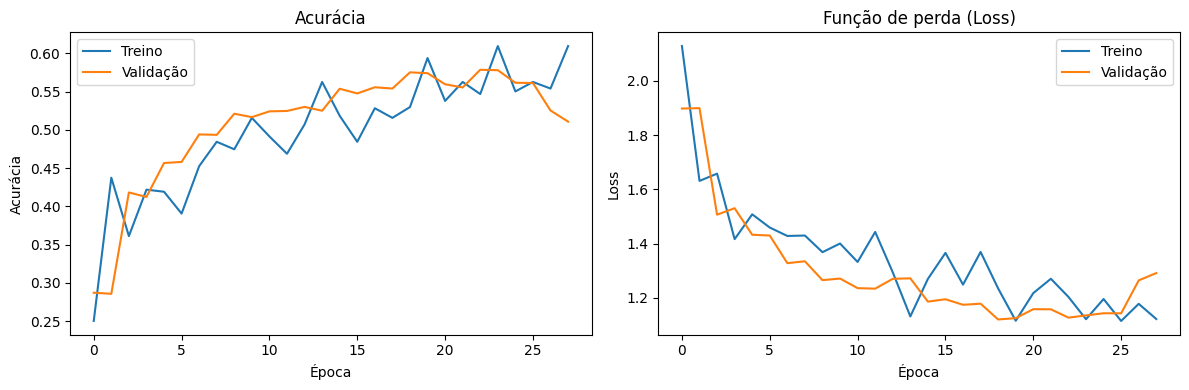

In [ ]:
#gráficos de treinamento

plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(historico.history['accuracy'], label='Treino')
plt.plot(historico.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(historico.history['loss'], label='Treino')
plt.plot(historico.history['val_loss'], label='Validação')
plt.title('Função de perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Acurácia no conjunto de teste: 0.5885

Relatório de classificação:

              precision    recall  f1-score   support

       Raiva       0.51      0.42      0.46       491
        Nojo       0.73      0.15      0.24        55
        Medo       0.38      0.28      0.32       528
       Feliz       0.78      0.86      0.82       879
      Triste       0.50      0.40      0.44       594
    Surpreso       0.63      0.81      0.71       416
      Neutro       0.52      0.66      0.58       626

    accuracy                           0.59      3589
   macro avg       0.58      0.51      0.51      3589
weighted avg       0.57      0.59      0.57      3589



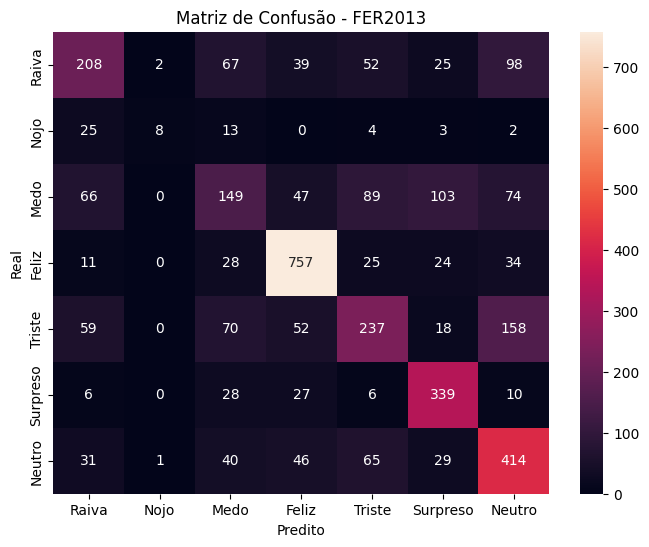

In [ ]:
#avaliação no conjunto de teste

# Carregar o melhor modelo salvo pelo checkpoint (garantia de melhor val_accuracy)
modelo_melhor = load_model("melhor_modelo_emocoes.h5")

perda_teste, acuracia_teste = modelo_melhor.evaluate(X_teste, y_teste, verbose=0)
print(f"Acurácia no conjunto de teste: {acuracia_teste:.4f}")

# Previsões para matriz de confusão e relatório
y_pred_probs = modelo_melhor.predict(X_teste, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_teste, axis=1)

print("\nRelatório de classificação:\n")
print(classification_report(y_true, y_pred, target_names=[mapa_emocoes[i] for i in range(7)]))

# Matriz de confusão
mat_conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf,
            annot=True,
            fmt="d",
            xticklabels=[mapa_emocoes[i] for i in range(7)],
            yticklabels=[mapa_emocoes[i] for i in range(7)])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - FER2013')
plt.show()


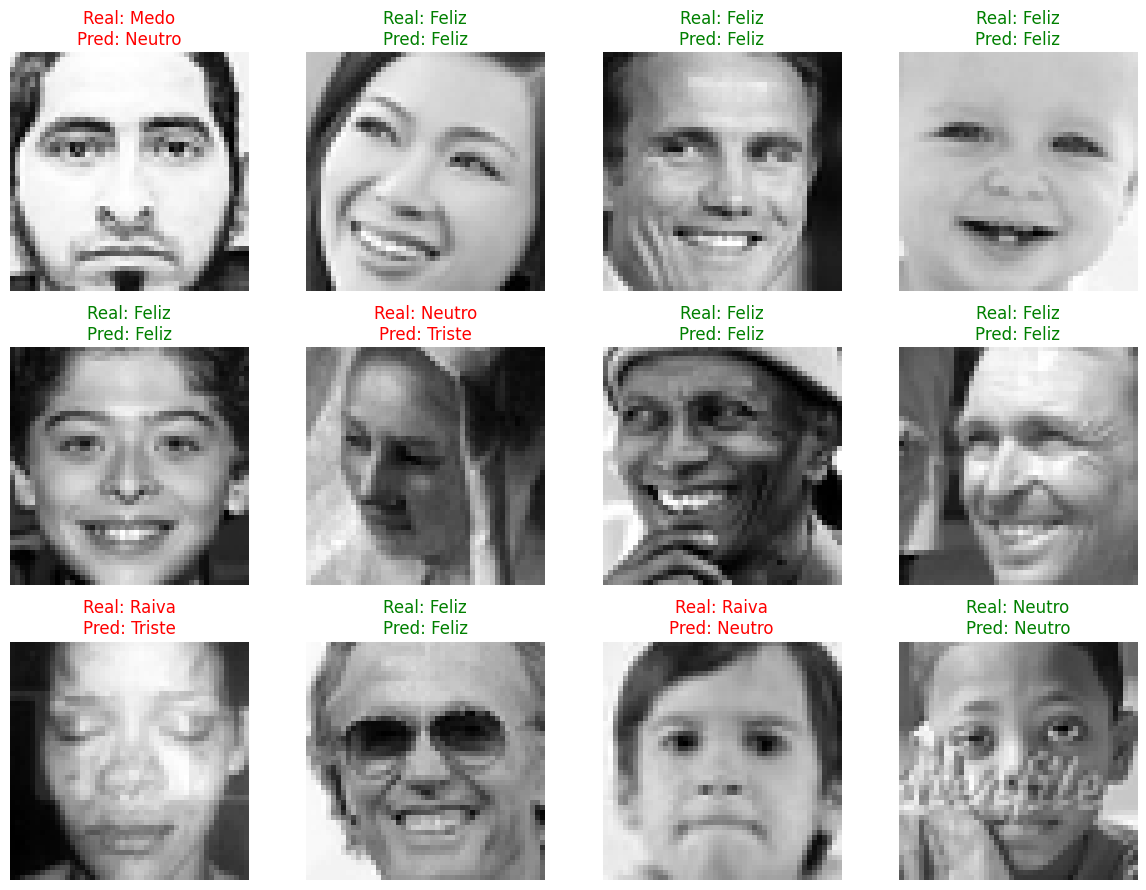

In [ ]:
# Exemplos de previsões no conjunto de teste (acertos x erros)

# seleciona 12 imagens aleatórias do teste
indices = np.random.choice(X_teste.shape[0], size=12, replace=False)

imagens_sel = X_teste[indices]
y_true_sel = np.argmax(y_teste[indices], axis=1)
y_pred_sel = np.argmax(modelo_melhor.predict(imagens_sel, verbose=0), axis=1)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    img = imagens_sel[i].reshape(48, 48)
    real = mapa_emocoes[y_true_sel[i]]
    pred = mapa_emocoes[y_pred_sel[i]]

    cor = "green" if y_true_sel[i] == y_pred_sel[i] else "red"

    ax.imshow(img, cmap="gray")
    ax.set_title(f"Real: {real}\nPred: {pred}", color=cor)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#salvar modelo final e disponibilizar para download

nome_arquivo_modelo = "modelo_emocoes_fer2013.h5"
modelo_melhor.save(nome_arquivo_modelo)

from google.colab import files
files.download(nome_arquivo_modelo)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>